### Import

In [ ]:
import os, gc, warnings, random, math
import datetime
from datetime import timedelta
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import copy

warnings.filterwarnings('ignore')

from random import seed

from tensorflow.keras import backend as K
from tensorflow.keras import initializers

import pandas as pd
import numpy as np
import operator
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler #менее подвержан выбросам

from sklearn.model_selection import train_test_split

import itertools
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Настройки визуализации
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')
sns.set_context('paper')
%config InlineBackend.figure_format = 'svg' #Отображение графиков в формате svg
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40

## Определение функций

In [ ]:
def is_cat_changes(df, column_name):
    """функция определения первой разности катег/инд признака для текущей транзакции если признак изменился, то 1. Иначе 0."""
    df['TEMP'], categories = df[column_name].factorize()
    df[column_name + '_CHANGE'] = df.sort_values(['CARDID','DATE_TIME_SEC']).groupby('CARDID')['TEMP'].diff()
    df[column_name + '_CHANGE'].fillna(0, inplace=True)
    df.loc[df[column_name + '_CHANGE'] != 0, column_name + '_CHANGE'] = 1
    df.drop(columns=['TEMP'], inplace=True)
    return df, categories

def num_of_unic(df, column_name):
    """функция подсчета уникальных значений катег/инд признака по данной карте"""
    dfn = df.groupby('CARDID')[column_name].nunique()
    df = pd.merge(df, dfn, how='inner', left_on='CARDID', right_index=True)
    df.rename(columns={column_name + '_x': column_name, column_name + '_y': column_name + '_NUM'},
    inplace=True)
    return df

def cat_changes_num(df, column_name):
    """функция подсчета количества изменений катег. признака
    column_name = столбец, полученный через is_cat_changes"""
    column_name = column_name + '_CHANGE'
    dfn = df.groupby('CARDID')[column_name].sum()
    df = pd.merge(df, dfn, how='inner', left_on='CARDID', right_index=True)
    df.rename(columns={column_name + '_x': column_name, column_name + '_y': column_name + '_NUM'},
    inplace=True)
    return df

def one_hot_encoder(df, column_name):
    """функция кодирования категориальных признаков"""
    dfn = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dfn], axis=1)
    return df

def label_encoder(df, column_name, name_new_column=False):
    """функция кодирования категориальных признаков"""
    le = LabelEncoder()
    if name_new_column==False:
      name_new_column = column_name + '_labled'
    column_name_label = name_new_column
    df[column_name_label] = le.fit_transform(df[column_name])
    return df

def frequency_encoder (df, column_name):
    """функция кодирования категориальных признаков"""
    freq = df.groupby(column_name).size()/len(df)
    column_name_freq = column_name + '_freq'
    df.loc[:,column_name_freq] = df[column_name].map(freq)
    return df

def num_of_unic_rel(df, column_name):
    """нахождение относительного значения"""
    column_name_num = column_name + '_NUM'
    df[column_name_num + '_REL'] = df[column_name_num] / df['COUNT_OF_TRANSACTIONS']
    return df

def cat_changes_num_rel(df, column_name):
    """нахождение относительного значения"""
    column_name_num = column_name + '_CHANGE_NUM'
    df[column_name_num + '_REL'] = df[column_name_num] / df['COUNT_OF_TRANSACTIONS']
    return df

## Основные параметры модуля

In [ ]:
DATA_PATH = '../data/'
PNG_PATH = '../png/'
PREPROCESSED_DATA_PATH = '../preprocessed data/'
SYNTHETIC_DATA_PATH = '../synthetic data/'

MIN_HISTORY_NUM = 20         # Минимальная история транзакций по карте
INTERVAL_BAD_TIME = 1        # Интервал между транзакциями которые стоит удалить
RATE_OF_BAD_INTERVAL = 0.05  # Отношение транзакций с низким интервалом к транзакциям с большим интервалом. Карты имеющие большее соотношение будут удалены 
MIN_FEATURES_NUM = 1         # Мин. допустимое количество невырожденных признаков для отдельных карт
MIN_HISTORY_WINDOW = 86400   # Мин. промежуток между первой и последней транзакцией
MIN_MEAN_DIFF_TIME = 3600    # Мин. среднее межтранзакционное время для отдельных карт

## Подготовка данных SVISTA

### Данные 

In [ ]:
dff = pd.read_csv(f"{DATA_PATH}/svista.txt", delimiter="\t", thousands=' ')

#### Структура данных

In [ ]:
dff.head(5) #отображение структуры набора данных

In [ ]:
dff.describe() 

In [ ]:
print('Кол-во исходных признаков:', len(dff.columns))
print(list(dff.columns))
print(dff.info())
for column in dff.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(dff[column].unique()), '\n', "Unique data:", dff[column].unique()[:5], sep='')

#### Приведение типов, заполнение пропусков

In [ ]:
#### Преобрзования бинарных столбцов и заполнение пропусков
dff["MARKED_DATE"].fillna(0, inplace = True)
dff["AUTH_RESP_CODE_FM"].fillna(1, inplace = True)
dff["AUTH_RESP_CODE"].fillna(-1, inplace = True)
dff["MERCH_COUNTRY"].fillna("<NA>", inplace = True)
dff["MERCH_POSTAL_CODE"].fillna("<NA>", inplace = True)
dff["MERCH_CITY"].fillna("<NA>", inplace = True)
dff.drop(['ACQ_INSTITUTION_ID','OFFLINE_PIN_PRES','ECI'], axis='columns', inplace=True) #Удаление столбцов имеющих 1 униклаьное значение

#### Преобразуем метку класса 1 фрод 0 легальная
for i in range(0,(len(dff))):
  if (dff['MARKED_DATE'][i] != 0):
    dff['MARKED_DATE'][i] = 1

print('Кол-во мошеннеческих транзакций:', dff["MARKED_DATE"].sum())

In [ ]:
#Автоматическое приведение типов
dfc=dff.convert_dtypes()
#Ручное приведение типов
dfc = dfc.astype({"CARD_EXPR_DATE" : 'int16', 
                  "MCC": 'int16', 
                  "AUTH_RESP_CODE": 'int16', 
                  "TRANS_TYPE" : 'int16', 
                  "PDC_CARDHOLDER_PRES":'int8',
                  "CVV2_PRES":'int8', 
                  "PDC_CARD_PRES":'bool',
                  "PDC_CARD_CAPTURE_CAP":'bool',
                  "AUTH_RESP_CODE_FM":'bool',
                  "PIN_PRES":'bool',
                  "MARKED_DATE":'bool'})

In [ ]:
dfc.info() #Проверяем полученные типы и наличие пропусков

#### Преобразование даты в число секунд

In [ ]:
dfc['DATE_TIME_SEC'] = np.nan #Создание нового пустого столбца

for i in tqdm(range(0,(len(dfc['DATE_TIME'])))):
  dfc['DATE_TIME_SEC'][i] = time.mktime(datetime.datetime.strptime(dfc['DATE_TIME'][i], "%m/%d/%Y %I:%M:%S.%f %p").timetuple())

dfc = dfc.astype({"DATE_TIME_SEC" : 'int'})

100%|██████████████████████████████████████████████████████████████████████████| 64999/64999 [00:13<00:00, 4956.23it/s]


#### Удаление дубликатов

In [ ]:
# Вывод дубликатов
dfc_duplicated = dfc[dfc.duplicated(keep=False)]
dfc_duplicated

In [ ]:
# Создаем новый dataframe не содержащий дубликатов
before_drop_duplicates = dfc.size/len(dfc.columns)
dfc1 = dfc.copy(deep=True)
dfc1.drop_duplicates(inplace=True)         # Удаляем дубликаты
after_drop_duplicates = dfc1.size/len(dfc1.columns)

if after_drop_duplicates == before_drop_duplicates:
  print("Дубликатов нет")
else:
  print("Дубликаты есть")
  print('Кол-во данных до удаления дубликатов:', before_drop_duplicates)
  print('Кол-во данных после удаления дубликатов:', after_drop_duplicates)

dfc1.reset_index(drop=True, inplace=True)

In [ ]:
# Проверяем остались ли дубликаты
dfc1_duplicated = dfc1[dfc1.duplicated(keep=False)]
dfc1_duplicated

### Удаление лишних данных, преобразование категориальных признаков, добавление новых признаков

#### Удаление мошеннических транзакций

In [ ]:
print('Кол-во данных с фродом:', len(dfc1))

#Используем только легальные транзакции
dfc1 = dfc1[dfc1['MARKED_DATE']==0]

print('Кол-во данных без фрода:', len(dfc1))
dftemp = dfc1.copy(deep=True)
dftemp.reset_index(drop=True, inplace=True)
dfn = dftemp.groupby('CARDID')['AMOUNT'].agg('count')
print('\n','Выводим кол-во транзакций по каждой карте:','\n',dfn.sort_values(ascending=False).head(30), sep='')

#### Удаление транзакций по картам имеющим малую историю + добавление признаков

In [ ]:
#Подсчет транзакций по картам
dfn = dftemp.groupby('CARDID')['AMOUNT'].agg('count')
dftemp = pd.merge(dftemp, dfn, how='inner', left_on='CARDID', right_index=True)
dftemp.rename(columns={'AMOUNT_x': 'AMOUNT', 'AMOUNT_y': 'COUNT_OF_TRANSACTIONS'}, inplace=True)
df_svista = dftemp.copy(deep=True)

#Оставляем карты которые имеют более MIN_HISTORY_NUM транзакций
print(f'Оставляем карты которые имеют >= {MIN_HISTORY_NUM} транзакций')
df_svista = df_svista[df_svista['COUNT_OF_TRANSACTIONS']>=MIN_HISTORY_NUM]

df_svista = df_svista.sort_values(['COUNT_OF_TRANSACTIONS'], ascending=False)
df_svista.reset_index(drop=True, inplace=True)

### Добавляем новый признак
# время с момента совершения предыдущей транзакции
# если транзакция первая по времени, то время заполняется средним
df_svista['TIME_DIFF'] = df_svista.sort_values(['CARDID','DATE_TIME_SEC']).groupby('CARDID')['DATE_TIME_SEC'].diff()
df_svista['TIME_DIFF'] = df_svista.groupby('CARDID')['TIME_DIFF'].transform(lambda x: x.fillna(x.mean()))

Оставляем карты которые имеют >= 20 транзакций


In [ ]:
print(f'Кол-во карт имеющих {MIN_HISTORY_NUM} или более транзакций:', len(df_svista['CARDID'].unique()))
print('Суммарное кол-во транзакций:', len(df_svista))
print('Срденее кол-во транзакций по карте', df_svista['COUNT_OF_TRANSACTIONS'].mean())
print('Мода:', list(df_svista['COUNT_OF_TRANSACTIONS'].mode())[0])
print(f'Кол-во карт и транзакций по картам имеющих менее {MIN_HISTORY_NUM*2} тразакций:','\n', len(df_svista[df_svista['COUNT_OF_TRANSACTIONS']<(MIN_HISTORY_NUM*2)]['CARDID'].unique()),
      '\n',len(df_svista[df_svista['COUNT_OF_TRANSACTIONS']<(MIN_HISTORY_NUM*2)]) ,sep='')

In [ ]:
f = plt.figure()
sns.histplot(df_svista['COUNT_OF_TRANSACTIONS'], bins = int(500/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_transactions_start.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_transactions_start', dpi=300)

In [ ]:
df_claster_v = pd.DataFrame({'CARDID':list(df_svista['CARDID'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID')['AMOUNT'].agg('count'))})
f = plt.figure()
sns.histplot(df_claster_v['COUNT_OF_TRANSACTIONS'], bins = int(500/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_cards_start.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_cards_start', dpi=300)

#### Удаление лишних признаков

In [ ]:
# Количество признаков которые выраждаются если спользовать только данные карты
summ = 0
print('Вырожденные признаки:')
for i in df_svista.columns:
  if len(df_svista[i].unique())==1:
    summ = summ + 1
    print(i)
print('Кол-во вырожденных признаков:', summ)

### Удаляем признаки с одним значением
for i in df_svista.columns:
  if len(df_svista[i].unique())==1:
    df_svista.drop(columns=[i],inplace=True)

### Удаляем другие признаки
df_svista.drop(columns=['CARD_EXPR_DATE','DATE_TIME'],inplace=True)

Вырожденные признаки:
AUTH_RESP_CODE_FM
MARKED_DATE
Кол-во вырожденных признаков: 2


In [ ]:
print('Кол-во уникальных значений в каждом признаке:')
for i in df_svista.columns:
  print("%-23s%5d" % (i+":",len(df_svista[i].unique())))

#### Кодирование категориальных призаков

In [ ]:
#Frequency Encoding
for i in ['MCC','TERMINAL_ID','AUTH_RESP_CODE','PDC_CARDHOLDER_PRES','MERCH_COUNTRY','MERCH_CITY','MERCH_POSTAL_CODE','MERCH_ID','CVV2_PRES','TRANS_TYPE','PDC_CARD_CAPTURE_CAP','PDC_CARD_PRES','PIN_PRES']:
  df_svista = frequency_encoder(df_svista, i)

df_svista.drop(columns=['MCC','TERMINAL_ID','AUTH_RESP_CODE','PDC_CARDHOLDER_PRES','MERCH_COUNTRY','MERCH_CITY','MERCH_POSTAL_CODE','MERCH_ID',\
                        'CVV2_PRES','TRANS_TYPE','PDC_CARD_CAPTURE_CAP','PDC_CARD_PRES','PIN_PRES'],inplace=True)

In [ ]:
#OneHotEncoding. Вместо него используется частотное кодирование
"""
for i in ['MCC','TERMINAL_ID','AUTH_RESP_CODE','PDC_CARDHOLDER_PRES','MERCH_COUNTRY','MERCH_CITY','MERCH_POSTAL_CODE','MERCH_ID','CVV2_PRES','TRANS_TYPE']:
  df_svista = one_hot_encoder(df_svista, i)

df_svista.drop(columns=['MCC','TERMINAL_ID','AUTH_RESP_CODE','PDC_CARDHOLDER_PRES','MERCH_COUNTRY','MERCH_CITY','MERCH_POSTAL_CODE','MERCH_ID','CVV2_PRES','TRANS_TYPE'],inplace=True)
"""

"\nfor i in ['MCC','TERMINAL_ID','AUTH_RESP_CODE','PDC_CARDHOLDER_PRES','MERCH_COUNTRY','MERCH_CITY','MERCH_POSTAL_CODE','MERCH_ID','CVV2_PRES','TRANS_TYPE']:\n  df_svista = one_hot_encoder(df_svista, i)\n\ndf_svista.drop(columns=['MCC','TERMINAL_ID','AUTH_RESP_CODE','PDC_CARDHOLDER_PRES','MERCH_COUNTRY','MERCH_CITY','MERCH_POSTAL_CODE','MERCH_ID','CVV2_PRES','TRANS_TYPE'],inplace=True)\n"

In [ ]:
### Label encoding. Решено использовать вместо него One Hot Encoder
"""
columns_to_encode = ['TERMINAL_ID','PDC_CARDHOLDER_PRES','CVV2_PRES','TRANS_TYPE','MCC','MERCH_COUNTRY','AUTH_RESP_CODE','MERCH_POSTAL_CODE',\
                     'MERCH_CITY', 'MERCH_ID']
for thecolumn in columns_to_encode:
  label_encoder(df_svista, thecolumn)

df_svista.drop(columns=['CARD_EXPR_DATE','DATE_TIME','MARKED_DATE','PIN_PRES','AUTH_RESP_CODE_FM','PDC_CARD_CAPTURE_CAP',\
                        'PDC_CARD_PRES','PDC_CARDHOLDER_PRES','CVV2_PRES','TRANS_TYPE','MCC','MERCH_COUNTRY','TERMINAL_ID',\
                        'AUTH_RESP_CODE','MERCH_POSTAL_CODE','MERCH_CITY', 'MERCH_ID'],inplace=True)
"""

"\ncolumns_to_encode = ['TERMINAL_ID','PDC_CARDHOLDER_PRES','CVV2_PRES','TRANS_TYPE','MCC','MERCH_COUNTRY','AUTH_RESP_CODE','MERCH_POSTAL_CODE',                     'MERCH_CITY', 'MERCH_ID']\nfor thecolumn in columns_to_encode:\n  label_encoder(df_svista, thecolumn)\n\ndf_svista.drop(columns=['CARD_EXPR_DATE','DATE_TIME','MARKED_DATE','PIN_PRES','AUTH_RESP_CODE_FM','PDC_CARD_CAPTURE_CAP',                        'PDC_CARD_PRES','PDC_CARDHOLDER_PRES','CVV2_PRES','TRANS_TYPE','MCC','MERCH_COUNTRY','TERMINAL_ID',                        'AUTH_RESP_CODE','MERCH_POSTAL_CODE','MERCH_CITY', 'MERCH_ID'],inplace=True)\n"

### Финальные преобразования

In [ ]:
### Сортировка
df_svista = df_svista.sort_values(['COUNT_OF_TRANSACTIONS','CARDID','DATE_TIME_SEC'], ascending=[False,False,True])
df_svista.reset_index(drop=True, inplace=True)

#### Удаляем карты имеющие низкий интервал между транзакциями

In [ ]:
print(f'Кол-во карт имеющих интервал в {INTERVAL_BAD_TIME} секунду или меньше ', len(df_svista[df_svista['TIME_DIFF']<=INTERVAL_BAD_TIME]['CARDID'].unique()),'/',len(df_svista['CARDID'].unique()), sep='')

In [ ]:
### Ищем карты транзакции которых имеют малый интервал времени
list_bad_cards = list(df_svista[df_svista['TIME_DIFF']<=INTERVAL_BAD_TIME]['CARDID'].unique())
df_bad_cards = df_svista.loc[df_svista['CARDID'].isin(list_bad_cards)]

In [ ]:
### Оставляем карты у которых частота встреч таких транзакций крайне мала
dftemp = df_svista[df_svista['TIME_DIFF']<=INTERVAL_BAD_TIME].copy(deep=True)
dftemp.reset_index(drop=True, inplace=True)
dftemp2 = dftemp.groupby('CARDID')['AMOUNT'].agg('count')
df_bad_cards = pd.merge(df_bad_cards, dftemp2, how='inner', left_on='CARDID', right_index=True)
df_bad_cards.rename(columns={'AMOUNT_x': 'AMOUNT', 'AMOUNT_y': 'COUNT_OF_BAD_TR'}, inplace=True)
df_bad_cards['BAD_RATE'] = df_bad_cards['COUNT_OF_BAD_TR']/df_bad_cards['COUNT_OF_TRANSACTIONS']
print(f'Удаляем карты у которых частота встречьтаких транзакций >={RATE_OF_BAD_INTERVAL}')
print('Кол-во удаляемых карт:', len(df_bad_cards[df_bad_cards['BAD_RATE']>=RATE_OF_BAD_INTERVAL]['CARDID'].unique()))
print('Кол-во удаляемых транзакций:', len(df_bad_cards[df_bad_cards['BAD_RATE']>=RATE_OF_BAD_INTERVAL]))
print('Кол-во оставляемых карт:', len(df_bad_cards[df_bad_cards['BAD_RATE']<RATE_OF_BAD_INTERVAL]['CARDID'].unique()))
print('Кол-во оставляемых транзакций:', len(df_bad_cards[df_bad_cards['BAD_RATE']<RATE_OF_BAD_INTERVAL]))

list_very_bad_cards = list(df_bad_cards[df_bad_cards['BAD_RATE']>=RATE_OF_BAD_INTERVAL]['CARDID'].unique())
df_svista = df_svista.loc[~df_svista['CARDID'].isin(list_very_bad_cards)]

In [ ]:
df_svista = df_svista.sort_values(['COUNT_OF_TRANSACTIONS','CARDID','DATE_TIME_SEC'], ascending=[False,False,True])
df_svista.reset_index(drop=True, inplace=True)
df_svista

#### Меняем ID на число

In [ ]:
#Преобразование названия карты (CARDID) в номер
j = 0
df_svista['CARDID_NUM'] = np.nan
df_svista['CARDID_NUM'][0] = j
for i in range(1,len(df_svista)):
  if df_svista['CARDID'][i-1] != df_svista['CARDID'][i] : 
    j+=1
  df_svista['CARDID_NUM'][i] = j
df_svista = df_svista.astype({"CARDID_NUM" : 'int'})


### Передвигаем столбец ID в начало
MOVING_COLUMN = df_svista['CARDID_NUM']
df_svista.drop(['CARDID_NUM'], axis=1, inplace=True)
df_svista.insert(0, 'CARDID_NUM', MOVING_COLUMN)

df_svista

#### Удаляем данныене неудовлетворяющие различным условиям

In [ ]:
additional_bad_card_list = np.array([])

#####Dictionary creating

In [ ]:
len(df_svista['CARDID_NUM'].unique())

In [ ]:
df_svista['CARDID_NUM'].unique()

In [ ]:
df_sv_card = {}

In [ ]:
#Построение словаря содержащего транзакции по отдельным картам
for i in tqdm(df_svista['CARDID_NUM'].unique()):
  df_sv_card[i]=df_svista[df_svista['CARDID_NUM']==i]
  #df_sv_card[i].drop(columns=['CARDID','CARDID_NUM','COUNT_OF_TRANSACTIONS'],inplace=True)
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

100%|████████████████████████████████████████████████████████████████████████████████| 189/189 [00:03<00:00, 62.82it/s]


##### Количество невырожденных признаков

In [ ]:
print("Количество признаков по каждой карте:")
features_per_card = []
for i in df_sv_card.keys():
  features_per_card.append([i,len(df_sv_card[i].columns)])
  #print(i,":", len(df_sv_card[i].columns))
features_per_card = np.array(features_per_card)
print(features_per_card[features_per_card[:, 1].argsort()])

additional_bad_card_list = np.hstack([additional_bad_card_list, features_per_card[features_per_card[:,1]<=MIN_FEATURES_NUM][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

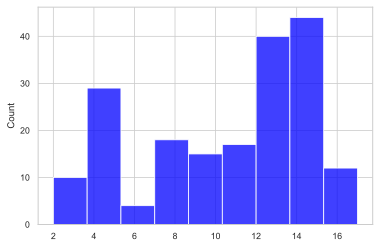

In [ ]:
f = plt.figure()
sns.histplot(data = features_per_card[:,1], color='blue')
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_features.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_features', dpi=300)


In [ ]:
additional_bad_card_list = np.hstack([additional_bad_card_list, features_per_card[features_per_card[:,1]<=MIN_FEATURES_NUM][:,0]])
additional_bad_card_list

array([], dtype=float64)

In [ ]:
# Проверка
#df_sv_card[4].columns

##### Общий промежуток времени между первой и последей транзакцией по картам

In [ ]:
#Время окна в которое укладываются все транзакции по карте
history_win = []
for i in df_sv_card.keys():
  history_win.append([i,df_sv_card[i]['DATE_TIME_SEC'].max()-df_sv_card[i]['DATE_TIME_SEC'].min()])
  #print(i,":",df_sv_card[i]['DATE_TIME_SEC'].max()-df_sv_card[i]['DATE_TIME_SEC'].min())
history_win = np.array(history_win)
print(history_win[history_win[:, 1].argsort()])

additional_bad_card_list = np.hstack([additional_bad_card_list, history_win[history_win[:,1]<=MIN_HISTORY_WINDOW][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

##### Среднее время между транзакцийями


In [ ]:
#Среднее время между транзакциями по карте
mean_diff_time =[]
for i in df_sv_card.keys():
  mean_diff_time.append([i,df_sv_card[i]['TIME_DIFF'].mean()])
  #print(i,":",df_sv_card[i]['TIME_DIFF'].mean())
mean_diff_time = np.array(mean_diff_time)

#print(mean_diff_time[mean_diff_time[:, 1].argsort()])
temp_arr = mean_diff_time[mean_diff_time[:, 1].argsort()]
for i in range(len(temp_arr)):
  print(temp_arr[i][0],':',temp_arr[i][1])
additional_bad_card_list = np.hstack([additional_bad_card_list, mean_diff_time[mean_diff_time[:,1]<=MIN_MEAN_DIFF_TIME][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

##### Удаление найденных плохих данных

In [ ]:
additional_bad_card_list = additional_bad_card_list.astype(int)
df_svista = df_svista.loc[~df_svista['CARDID_NUM'].isin(list(additional_bad_card_list))]
df_svista

In [ ]:
df_svista = df_svista.sort_values(['COUNT_OF_TRANSACTIONS','CARDID','DATE_TIME_SEC'], ascending=[False,False,True])
df_svista.reset_index(drop=True, inplace=True)

In [ ]:
df_svista.drop(['CARDID_NUM'], axis=1, inplace=True)
#Преобразование названия карты (CARDID) в номер
j = 0
df_svista['CARDID_NUM'] = np.nan
df_svista['CARDID_NUM'][0] = j
for i in range(1,len(df_svista)):
  if df_svista['CARDID'][i-1] != df_svista['CARDID'][i] : 
    j+=1
  df_svista['CARDID_NUM'][i] = j
df_svista = df_svista.astype({"CARDID_NUM" : 'int'})


### Передвигаем столбец ID в начало
MOVING_COLUMN = df_svista['CARDID_NUM']
df_svista.drop(['CARDID_NUM'], axis=1, inplace=True)
df_svista.insert(0, 'CARDID_NUM', MOVING_COLUMN)

df_svista.drop(['CARDID','COUNT_OF_TRANSACTIONS'], axis=1, inplace=True)
df_svista

### Визуализация

In [ ]:
df_svista_visual = df_svista.copy(deep=True)

dftemp = df_svista_visual.copy(deep=True)
dfn = dftemp.groupby('CARDID_NUM')['AMOUNT'].agg('count')
dftemp = pd.merge(dftemp, dfn, how='inner', left_on='CARDID_NUM', right_index=True)
dftemp.rename(columns={'AMOUNT_x': 'AMOUNT', 'AMOUNT_y': 'COUNT_OF_TRANSACTIONS'}, inplace=True)
df_svista_visual = dftemp.copy(deep=True)

In [ ]:
f = plt.figure()
sns.histplot(df_svista_visual['COUNT_OF_TRANSACTIONS'],color='red', bins = int(350/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_transactions_final.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_transactions_final', dpi=300)

In [ ]:
df_claster_v = pd.DataFrame({'CARDID_NUM':list(df_svista['CARDID_NUM'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].agg('count'))})
f = plt.figure()
sns.histplot(df_claster_v['COUNT_OF_TRANSACTIONS'], color='red', bins = int(350/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_cards_final.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_cards_final', dpi=300)

In [ ]:
df_sv_card = {}

In [ ]:
#Построение словаря содержащего транзакции по отдельным картам
for i in tqdm(df_svista_visual['CARDID_NUM'].unique()):
  df_sv_card[i]=df_svista_visual[df_svista_visual['CARDID_NUM']==i]
  #df_sv_card[i].drop(columns=['CARDID','CARDID_NUM','COUNT_OF_TRANSACTIONS'],inplace=True)
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [00:02<00:00, 70.63it/s]


#### Количество транзакий в час

In [ ]:
%config InlineBackend.figure_format = 'png'
f = plt.figure(figsize=(20,500))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
gs = f.add_gridspec(math.ceil(len(df_sv_card.keys())/2), 2) # округленное в большую сторону деление на 2 количества карт
#gs = f.add_gridspec(math.ceil(94/2), 2)
for i in tqdm(df_sv_card.keys()): 
  df1 = df_sv_card[i].copy(deep=True)
  ####################
  minutes = df1['DATE_TIME_SEC']/60
  minutes = minutes.astype(int)
  df1['Minutes']=minutes
  hours = ((df1['Minutes']/60)) % 24
  hours = hours.astype(int)
  df1['Hours'] = hours
  ####################
  ax = f.add_subplot(gs[(int) (i/2), i % 2])
  ax.set_title(f"Транзакции по карте {i+1}")
  sns.countplot(data = df1,
                x = 'Hours',
                edgecolor=(0,0,0),
                linewidth=0.1,
                saturation=1)
plt.show()

In [ ]:
if not os.path.isfile(f'{PNG_PATH}/transactions_per_hour.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/transactions_per_hour', dpi=100)
#thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_hour_{thetime}.svg')
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_hour_{thetime}.png', dpi=300)

#### Количество транзакий в день

In [ ]:
%config InlineBackend.figure_format = 'png'
f = plt.figure(figsize=(35,500))
#plt.figure(figsize=(40,6))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
gs = f.add_gridspec(math.ceil(len(df_sv_card.keys())/2), 2)
for i in df_sv_card.keys(): 
  df1 = df_sv_card[i].copy(deep=True)
  DAY = (df1['DATE_TIME_SEC']/86400)
  DAY = DAY.astype(int)
  df1['DAY']=DAY
  ax = f.add_subplot(gs[(int) (i/2), i % 2])
  ax.set_title(f"Транзакции по карте {i+1}")
  sns.countplot(data = df1,
                x = 'DAY',
                edgecolor=(0,0,0),
                linewidth=0.3,
                saturation=1)

plt.show()

In [ ]:
if not os.path.isfile(f'{PNG_PATH}/transactions_per_day.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/transactions_per_day', dpi=100)
#thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_day_{thetime}.svg')
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_day_{thetime}.png', dpi=300)

#### Распределение всех транзакций по часам

In [ ]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(18,10))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = df_svista_visual.copy(deep=True)
####################
minutes = df1['DATE_TIME_SEC']/60
minutes = minutes.astype(int)
df1['Minutes']=minutes
hours = ((df1['Minutes']/60)-417384) % 24
hours = hours.astype(int)
df1['Hours'] = hours
####################
sns.countplot(data = df1,
              x = 'Hours',
              edgecolor=(0,0,0),
              linewidth=0.1,
              saturation=1)
if not os.path.isfile(f'{PNG_PATH}/transactions_per_hour_ALL.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/transactions_per_hour_ALL', dpi=300)
#thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_hour_ALL27_{thetime}.svg')
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_hour_ALL27_{thetime}.png', dpi=300)
plt.show()

#### Распределение всех транзакций по дням

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.figure(figsize=(60,10))
#plt.figure(figsize=(40,6))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = df_svista_visual.copy(deep=True)
DAY = (df1['DATE_TIME_SEC']/86400)
DAY = DAY.astype(int)
DAY = DAY - DAY.min()
df1['DAY']=DAY
sns.countplot(data = df1,
              x = 'DAY',
              edgecolor=(0,0,0),
              linewidth=0.3,
              saturation=1)
if not os.path.isfile(f'{PNG_PATH}/transactions_per_day_ALL'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/transactions_per_day_ALL', dpi=300)
#thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_day_ALL27_{thetime}.svg')
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_day_ALL27_{thetime}.png', dpi=300)
plt.show()

### Сохранение

In [ ]:
if not os.path.isfile(f'{PREPROCESSED_DATA_PATH}prep_data.csv'):
  df_svista.to_csv(f'{PREPROCESSED_DATA_PATH}prep_data.csv', index=False)

In [ ]:
df_svista

In [ ]:
print('Кол-во признаков:', len(df_svista.columns))
print(list(df_svista.columns))
print(df_svista.info())
for column in df_svista.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_svista[column].unique()), '\n', "Unique data:", df_svista[column].unique()[:5], sep='')

## Обработка сгенерированных данных IM

---



### Данные 

In [ ]:
df_IM_initial = pd.read_csv(f'{SYNTHETIC_DATA_PATH}synthetic_data_IM_initial.csv', parse_dates=True)
df_IM_initial.drop(columns=['isLegal','m_x','m_y', 'product_type'],inplace=True)
df_IM_initial.columns = ['CARDID_NUM', 'MERCH_ID', 'DATE', 'TIME','TRANS_TYPE', 'AMOUNT']

#### Структура данных

In [ ]:
df_IM_initial.head(5) #отображение структуры набора данных

In [ ]:
df_IM_initial.describe() 

In [ ]:
print('Кол-во исходных признаков:', len(df_IM_initial.columns))
print(list(df_IM_initial.columns))
print(df_IM_initial.info())
for column in df_IM_initial.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_IM_initial[column].unique()), '\n', "Unique data:", df_IM_initial[column].unique()[:5], sep='')

#### Преобразование даты в число секунд

In [ ]:
dfc = df_IM_initial.copy(deep=True)
dfc['DATE_TIME_SEC'] = np.nan
dfc['DATE_TIME_SEC'][0] = time.mktime(datetime.datetime.strptime(dfc['DATE'][0], "%Y-%m-%d").timetuple())

In [ ]:
dfc['DATE_TIME_SEC'][0]

In [ ]:
dfc = df_IM_initial.copy(deep=True)
dfc['DATE_TIME_SEC'] = np.nan #Создание нового пустого столбца

for i in tqdm(range(0,(len(dfc['DATE'])))):
  dfc['DATE_TIME_SEC'][i] = time.mktime(datetime.datetime.strptime(dfc['DATE'][i], "%Y-%m-%d").timetuple())

dfc = dfc.astype({"DATE_TIME_SEC" : 'int'})

dfc['DATE_TIME_SEC'] = dfc['DATE_TIME_SEC']+dfc['TIME']

dfc.drop(columns=['DATE','TIME'], inplace=True)

100%|████████████████████████████████████████████████████████████████████████| 238436/238436 [02:28<00:00, 1610.03it/s]


In [ ]:
dfc

#### Удаление дубликатов

In [ ]:
# Вывод дубликатов
dfc_duplicated = dfc[dfc.duplicated(keep=False)]
dfc_duplicated

,CARDID_NUM,MERCH_ID,TRANS_TYPE,AMOUNT,DATE_TIME_SEC


In [ ]:
# Создаем новый dataframe не содержащий дубликатов
before_drop_duplicates = dfc.size/len(dfc.columns)
dfc1 = dfc.copy(deep=True)
dfc1.drop_duplicates(inplace=True)         # Удаляем дубликаты
after_drop_duplicates = dfc1.size/len(dfc1.columns)

if after_drop_duplicates == before_drop_duplicates:
  print("Дубликатов нет")
else:
  print("Дубликаты есть")
  print('Кол-во данных до удаления дубликатов:', before_drop_duplicates)
  print('Кол-во данных после удаления дубликатов:', after_drop_duplicates)

dfc1.reset_index(drop=True, inplace=True)

Дубликатов нет


### Удаление лишних данных, преобразование категориальных признаков, добавление новых признаков

#### Удаление транзакций по картам имеющим малую историю + добавление признаков

In [ ]:
#Подсчет транзакций по картам
dftemp = dfc1.copy(deep=True)
dftemp.reset_index(drop=True, inplace=True)
dfn = dftemp.groupby('CARDID_NUM')['AMOUNT'].agg('count')
dftemp = pd.merge(dftemp, dfn, how='inner', left_on='CARDID_NUM', right_index=True)
dftemp.rename(columns={'AMOUNT_x': 'AMOUNT', 'AMOUNT_y': 'COUNT_OF_TRANSACTIONS'}, inplace=True)
df_svista = dftemp.copy(deep=True)

### Сортировка
df_svista = df_svista.sort_values(['COUNT_OF_TRANSACTIONS','CARDID_NUM','DATE_TIME_SEC'], ascending=[False,False,True])
df_svista.reset_index(drop=True, inplace=True)

### Выбираем первые 9 с наибольшим кол-вом транзакций
listofcards = []
count = 0
for i in df_svista['CARDID_NUM'].unique():
  listofcards.append(i)
  count+=1
  if count>=9:
    break;

df_svista = df_svista[df_svista['CARDID_NUM'].isin(listofcards)]

### Добавляем новый признак
# время с момента совершения предыдущей транзакции
# если транзакция первая по времени, то время заполняется средним
df_svista['TIME_DIFF'] = df_svista.sort_values(['CARDID_NUM','DATE_TIME_SEC']).groupby('CARDID_NUM')['DATE_TIME_SEC'].diff()
df_svista['TIME_DIFF'] = df_svista.groupby('CARDID_NUM')['TIME_DIFF'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
print(f'Кол-во карт:', len(df_svista['CARDID_NUM'].unique()))
print('Суммарное кол-во транзакций:', len(df_svista))
print('Срденее кол-во транзакций по карте', df_svista['COUNT_OF_TRANSACTIONS'].mean())
print('Мода:', list(df_svista['COUNT_OF_TRANSACTIONS'].mode())[0])

Кол-во карт: 9
Суммарное кол-во транзакций: 2366
Срденее кол-во транзакций по карте 262.9061707523246
Мода: 262


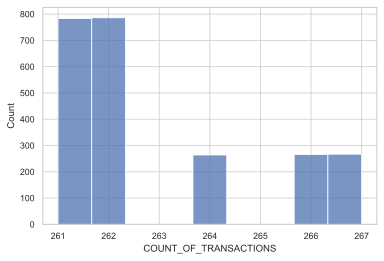

In [ ]:
f = plt.figure()
sns.histplot(df_svista['COUNT_OF_TRANSACTIONS'], bins = int(9))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_transactions_start_syn_IM.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_transactions_start_syn_IM', dpi=300)

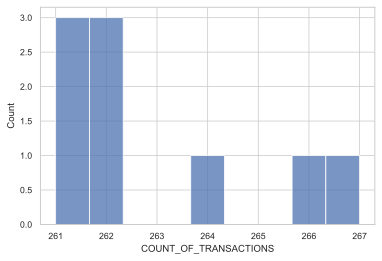

In [ ]:
df_claster_v = pd.DataFrame({'CARDID_NUM':list(df_svista['CARDID_NUM'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].agg('count'))})
f = plt.figure()
sns.histplot(df_claster_v['COUNT_OF_TRANSACTIONS'], bins = int(9))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_cards_start_syn_IM.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_cards_start_syn_IM', dpi=300)

#### Удаление лишних признаков

In [ ]:
# Количество признаков которые выраждаются если спользовать только данные карты
summ = 0
print('Вырожденные признаки:')
for i in df_svista.columns:
  if len(df_svista[i].unique())==1:
    summ = summ + 1
    print(i)
print('Кол-во вырожденных признаков:', summ)

Вырожденные признаки:
Кол-во вырожденных признаков: 0


In [ ]:
print('Кол-во уникальных значений в каждом признаке:')
for i in df_svista.columns:
  print("%-23s%5d" % (i+":",len(df_svista[i].unique())))

#### Кодирование категориальных призаков

In [ ]:
df_svista

In [ ]:
#Frequency Encoding
for i in ['TRANS_TYPE']:
  df_svista = frequency_encoder(df_svista, i)

df_svista.drop(columns=['TRANS_TYPE'],inplace=True)

### Финальные преобразования

In [ ]:
### Сортировка
df_svista = df_svista.sort_values(['COUNT_OF_TRANSACTIONS','CARDID_NUM','DATE_TIME_SEC'], ascending=[False,False,True])
df_svista.reset_index(drop=True, inplace=True)

#### Удаляем данныене неудовлетворяющие различным условиям

In [ ]:
additional_bad_card_list = np.array([])

#####Dictionary creating

In [ ]:
len(df_svista['CARDID_NUM'].unique())

9

In [ ]:
df_svista['CARDID_NUM'].unique()

array([824, 600,   1, 777, 754, 487, 965, 835, 550], dtype=int64)

In [ ]:
df_sv_card = {}

In [ ]:
#Построение словаря содержащего транзакции по отдельным картам
for i in tqdm(df_svista['CARDID_NUM'].unique()):
  df_sv_card[i]=df_svista[df_svista['CARDID_NUM']==i]
  #df_sv_card[i].drop(columns=['CARDID','CARDID_NUM','COUNT_OF_TRANSACTIONS'],inplace=True)
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.69it/s]


##### Количество невырожденных признаков

In [ ]:
print("Количество признаков по каждой карте:")
features_per_card = []
for i in df_sv_card.keys():
  features_per_card.append([i,len(df_sv_card[i].columns)])
  #print(i,":", len(df_sv_card[i].columns))
features_per_card = np.array(features_per_card)
print(features_per_card[features_per_card[:, 1].argsort()])

additional_bad_card_list = np.hstack([additional_bad_card_list, features_per_card[features_per_card[:,1]<=MIN_FEATURES_NUM][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

Количество признаков по каждой карте:
[[824   5]
 [600   5]
 [  1   5]
 [777   5]
 [754   5]
 [487   5]
 [965   5]
 [835   5]
 [550   5]]
___________________________________________________________________________________
[]


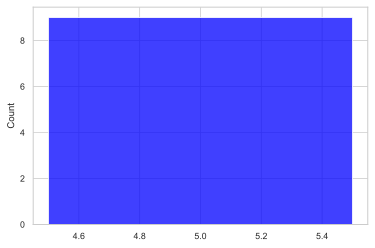

In [ ]:
f = plt.figure()
sns.histplot(data = features_per_card[:,1], color='blue')
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_features.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_features', dpi=300)


In [ ]:
additional_bad_card_list = np.hstack([additional_bad_card_list, features_per_card[features_per_card[:,1]<=MIN_FEATURES_NUM][:,0]])
additional_bad_card_list

array([], dtype=float64)

In [ ]:
# Проверка
#df_sv_card[4].columns

##### Общий промежуток времени между первой и последей транзакцией по картам

In [ ]:
#Время окна в которое укладываются все транзакции по карте
history_win = []
for i in df_sv_card.keys():
  history_win.append([i,df_sv_card[i]['DATE_TIME_SEC'].max()-df_sv_card[i]['DATE_TIME_SEC'].min()])
  #print(i,":",df_sv_card[i]['DATE_TIME_SEC'].max()-df_sv_card[i]['DATE_TIME_SEC'].min())
history_win = np.array(history_win)
print(history_win[history_win[:, 1].argsort()])

additional_bad_card_list = np.hstack([additional_bad_card_list, history_win[history_win[:,1]<=MIN_HISTORY_WINDOW][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

##### Среднее время между транзакцийями


In [ ]:
#Среднее время между транзакциями по карте
mean_diff_time =[]
for i in df_sv_card.keys():
  mean_diff_time.append([i,df_sv_card[i]['TIME_DIFF'].mean()])
  #print(i,":",df_sv_card[i]['TIME_DIFF'].mean())
mean_diff_time = np.array(mean_diff_time)

#print(mean_diff_time[mean_diff_time[:, 1].argsort()])
temp_arr = mean_diff_time[mean_diff_time[:, 1].argsort()]
for i in range(len(temp_arr)):
  print(temp_arr[i][0],':',temp_arr[i][1])
additional_bad_card_list = np.hstack([additional_bad_card_list, mean_diff_time[mean_diff_time[:,1]<=MIN_MEAN_DIFF_TIME][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

##### Удаление найденных плохих данных

In [ ]:
additional_bad_card_list = additional_bad_card_list.astype(int)
df_svista = df_svista.loc[~df_svista['CARDID_NUM'].isin(list(additional_bad_card_list))]
df_svista

,CARDID_NUM,MERCH_ID,AMOUNT,DATE_TIME_SEC,COUNT_OF_TRANSACTIONS,TIME_DIFF,TRANS_TYPE_freq
0,824,0,70,1577885084,267,38991.706767,0.756974
1,824,45,100,1577886594,267,1510.000000,0.756974
2,824,6,300,1577970817,267,84223.000000,0.756974
3,824,32,250,1577972429,267,1612.000000,0.150042
4,824,1,100,1578057590,267,85161.000000,0.756974
...,...,...,...,...,...,...,...
2361,550,26,250,1588064829,261,2460.000000,0.150042
2362,550,41,150,1588144449,261,79620.000000,0.756974
2363,550,7,200,1588146278,261,1829.000000,0.756974
2364,550,27,500,1588149170,261,2892.000000,0.083686


In [ ]:
df_svista = df_svista.sort_values(['COUNT_OF_TRANSACTIONS','CARDID_NUM','DATE_TIME_SEC'], ascending=[False,False,True])
df_svista.reset_index(drop=True, inplace=True)

In [ ]:
df_svista.drop(['COUNT_OF_TRANSACTIONS'], axis=1, inplace=True)
df_svista

### Визуализация

In [ ]:
df_svista_visual = df_svista.copy(deep=True)

dftemp = df_svista_visual.copy(deep=True)
dfn = dftemp.groupby('CARDID_NUM')['AMOUNT'].agg('count')
dftemp = pd.merge(dftemp, dfn, how='inner', left_on='CARDID_NUM', right_index=True)
dftemp.rename(columns={'AMOUNT_x': 'AMOUNT', 'AMOUNT_y': 'COUNT_OF_TRANSACTIONS'}, inplace=True)
df_svista_visual = dftemp.copy(deep=True)

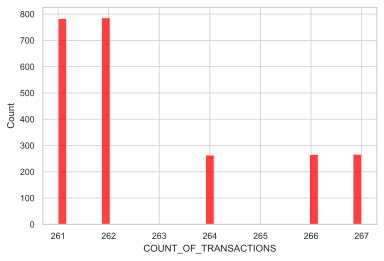

In [ ]:
f = plt.figure()
sns.histplot(df_svista_visual['COUNT_OF_TRANSACTIONS'],color='red', bins = int(350/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_transactions_final_syn_IM.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_transactions_final_syn_IM', dpi=300)

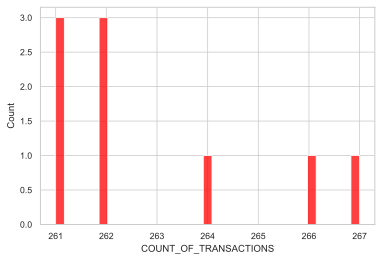

In [ ]:
df_claster_v = pd.DataFrame({'CARDID_NUM':list(df_svista['CARDID_NUM'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].agg('count'))})
f = plt.figure()
sns.histplot(df_claster_v['COUNT_OF_TRANSACTIONS'], color='red', bins = int(350/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_cards_final_syn_IM.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_cards_final_syn_IM', dpi=300)

In [ ]:
df_sv_card = {}

In [ ]:
#Построение словаря содержащего транзакции по отдельным картам
for i in tqdm(df_svista_visual['CARDID_NUM'].unique()):
  df_sv_card[i]=df_svista_visual[df_svista_visual['CARDID_NUM']==i]
  #df_sv_card[i].drop(columns=['CARDID','CARDID_NUM','COUNT_OF_TRANSACTIONS'],inplace=True)
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 128.56it/s]


#### Количество транзакий в час

In [ ]:
df_sv_card.keys()

dict_keys([824, 600, 1, 777, 754, 487, 965, 835, 550])

9it [00:00, 21.23it/s]


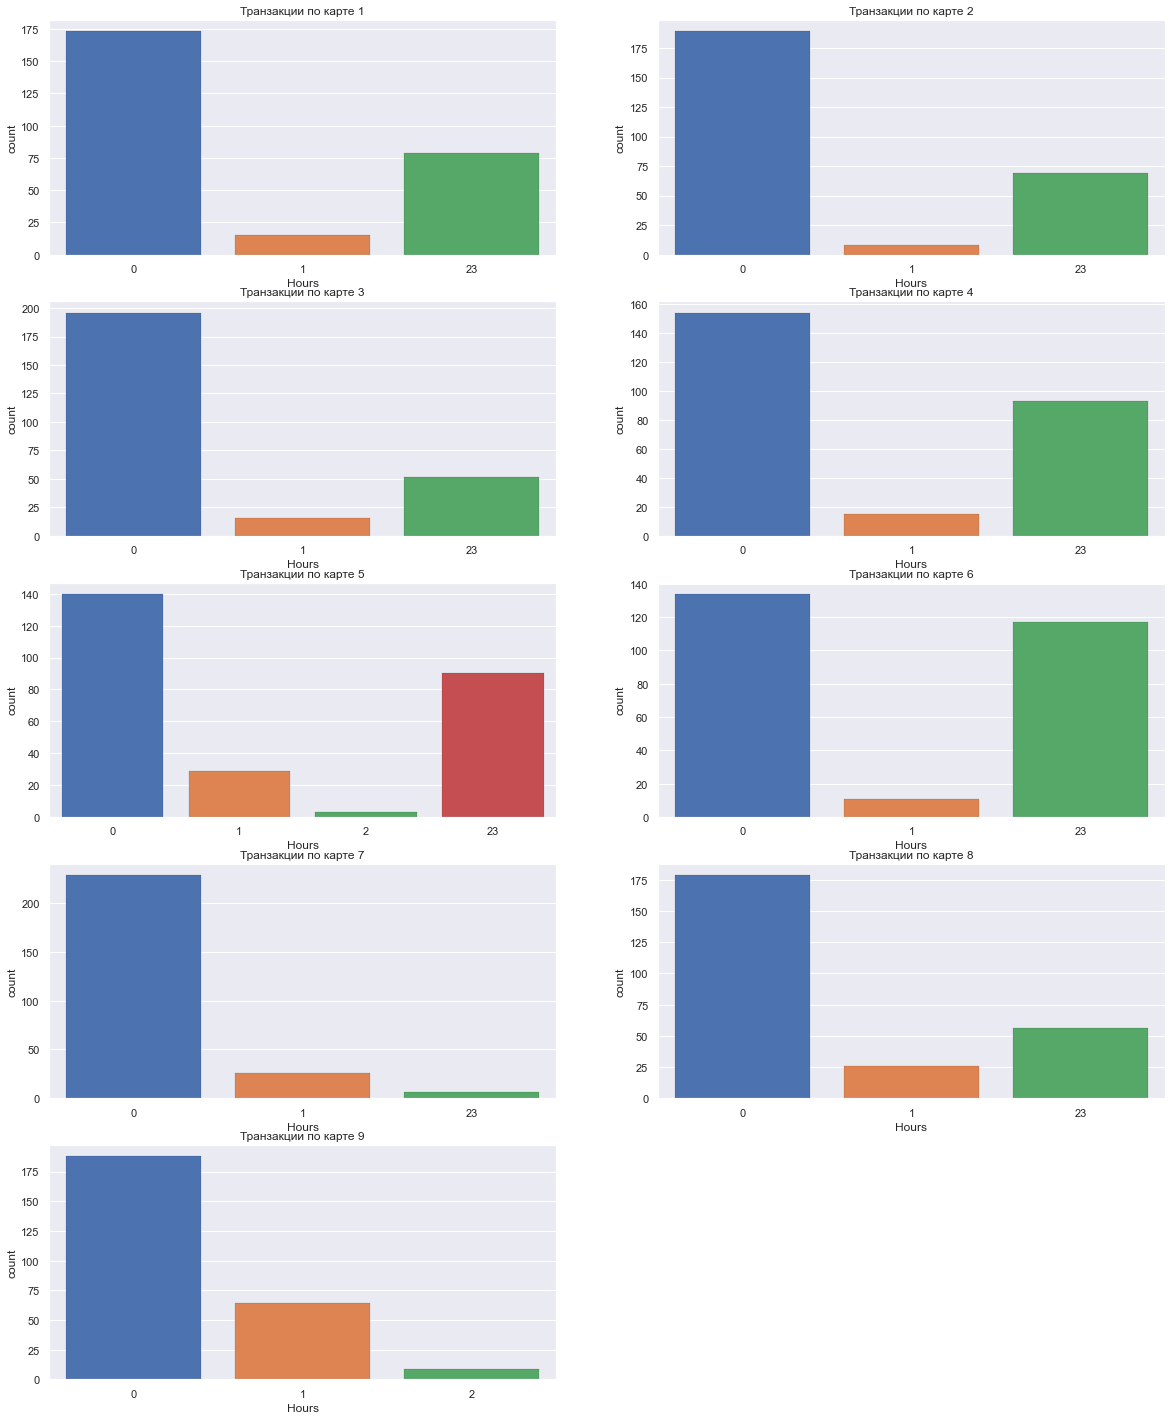

In [ ]:
%config InlineBackend.figure_format = 'png'
f = plt.figure(figsize=(20,25))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
gs = f.add_gridspec(math.ceil(len(df_sv_card.keys())/2), 2) # округленное в большую сторону деление на 2 количества карт
#gs = f.add_gridspec(math.ceil(94/2), 2)
for i, index  in tqdm(enumerate(df_sv_card.keys())): 
  df1 = df_sv_card[index].copy(deep=True)
  ####################
  minutes = df1['DATE_TIME_SEC']/60
  minutes = minutes.astype(int)
  df1['Minutes']=minutes
  hours = ((df1['Minutes']/60)) % 24
  hours = hours.astype(int)
  df1['Hours'] = hours
  ####################
  ax = f.add_subplot(gs[(int) (i/2), i % 2])
  ax.set_title(f"Транзакции по карте {i+1}")
  sns.countplot(data = df1,
                x = 'Hours',
                edgecolor=(0,0,0),
                linewidth=0.1,
                saturation=1)
plt.show()

In [ ]:
if not os.path.isfile(f'{PNG_PATH}/transactions_per_hour_syn_IM.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/transactions_per_hour_syn_IM', dpi=100)
#thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_hour_{thetime}.svg')
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_hour_{thetime}.png', dpi=300)

#### Количество транзакий в день

In [ ]:
%config InlineBackend.figure_format = 'png'
f = plt.figure(figsize=(80,50))
#plt.figure(figsize=(40,6))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
gs = f.add_gridspec(math.ceil(len(df_sv_card.keys())/2), 2)
for i, index in enumerate(df_sv_card.keys()): 
  df1 = df_sv_card[index].copy(deep=True)
  DAY = (df1['DATE_TIME_SEC']/86400)
  DAY = DAY.astype(int)
  df1['DAY']=DAY
  ax = f.add_subplot(gs[(int) (i/2), i % 2])
  ax.set_title(f"Транзакции по карте {i+1}")
  sns.countplot(data = df1,
                x = 'DAY',
                edgecolor=(0,0,0),
                linewidth=0.3,
                saturation=1)

plt.show()

In [ ]:
if not os.path.isfile(f'{PNG_PATH}/transactions_per_day_sym_IM.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/transactions_per_day_sym_IM', dpi=100)
#thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_day_{thetime}.svg')
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_day_{thetime}.png', dpi=300)

#### Распределение всех транзакций по часам

In [ ]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(18,10))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = df_svista_visual.copy(deep=True)
####################
minutes = df1['DATE_TIME_SEC']/60
minutes = minutes.astype(int)
df1['Minutes']=minutes
hours = ((df1['Minutes']/60)-417384) % 24
hours = hours.astype(int)
df1['Hours'] = hours
####################
sns.countplot(data = df1,
              x = 'Hours',
              edgecolor=(0,0,0),
              linewidth=0.1,
              saturation=1)
if not os.path.isfile(f'{PNG_PATH}/transactions_per_hour_ALL_syn_IM.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/transactions_per_hour_ALL_syn_IM', dpi=300)
#thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_hour_ALL27_{thetime}.svg')
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_hour_ALL27_{thetime}.png', dpi=300)
plt.show()

#### Распределение всех транзакций по дням

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.figure(figsize=(60,10))
#plt.figure(figsize=(40,6))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = df_svista_visual.copy(deep=True)
DAY = (df1['DATE_TIME_SEC']/86400)
DAY = DAY.astype(int)
DAY = DAY - DAY.min()
df1['DAY']=DAY
sns.countplot(data = df1,
              x = 'DAY',
              edgecolor=(0,0,0),
              linewidth=0.3,
              saturation=1)
if not os.path.isfile(f'{PNG_PATH}/transactions_per_day_ALL_syn_IM'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/transactions_per_day_ALL_syn_IM', dpi=300)
#thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_day_ALL27_{thetime}.svg')
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_day_ALL27_{thetime}.png', dpi=300)
plt.show()

### Сохранение

In [ ]:
if not os.path.isfile(f'{PREPROCESSED_DATA_PATH}prep_data_syn_IM.csv'):
  df_svista.to_csv(f'{PREPROCESSED_DATA_PATH}prep_data_syn_IM.csv', index=False)

In [ ]:
df_svista

In [ ]:
print('Кол-во признаков:', len(df_svista.columns))
print(list(df_svista.columns))
print(df_svista.info())
for column in df_svista.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_svista[column].unique()), '\n', "Unique data:", df_svista[column].unique()[:5], sep='')

## Обработка сгенерированных данных DS

---



### Данные 

In [ ]:
df_dir = {}
for i in range(9):
  df_dir[i] = pd.read_csv(f'{SYNTHETIC_DATA_PATH}sythetic_data_DS_card_{i}.csv')

In [ ]:
for i in df_dir.keys():
  df_dir[i]['CARDID_NUM'] = i
  df_dir[i] = df_dir[i].sort_values(['DATE_TIME_SEC'], ascending=[True])
  df_dir[i].reset_index(drop=True, inplace=True)

In [ ]:
df_DS = pd.concat([df_dir[0],df_dir[1]])
for i in range(2,len(df_dir.keys())):
  df_DS = pd.concat([df_DS,df_dir[i]])

In [ ]:
### Сортировка
df_DS = df_DS.sort_values(['CARDID_NUM','DATE_TIME_SEC'], ascending=[True,True])
df_DS.reset_index(drop=True, inplace=True)

#### Структура данных

In [ ]:
df_DS.head(5) #отображение структуры набора данных

,CARDID_NUM,AMOUNT,AMOUNT_INST,DATE_TIME_SEC,TIME_DIFF,MCC_freq,TERMINAL_ID_freq,AUTH_RESP_CODE_freq,PDC_CARDHOLDER_PRES_freq,MERCH_COUNTRY_freq,MERCH_CITY_freq,MERCH_POSTAL_CODE_freq,MERCH_ID_freq,CVV2_PRES_freq,TRANS_TYPE_freq,PDC_CARD_CAPTURE_CAP_freq,PDC_CARD_PRES_freq,PIN_PRES_freq
0,0,7300,7300,1.503552e+09,41741.133354,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
1,0,36500,36500,1.506903e+09,101492.413642,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
2,0,18000,18000,1.506904e+09,157806.111843,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
3,0,18000,18000,1.506951e+09,7118.404638,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578
4,0,36500,36500,1.506973e+09,151764.869561,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,0.954179,0.93024,0.987578


In [ ]:
df_DS.describe() 

,CARDID_NUM,AMOUNT,AMOUNT_INST,DATE_TIME_SEC,TIME_DIFF,MCC_freq,TERMINAL_ID_freq,AUTH_RESP_CODE_freq,PDC_CARDHOLDER_PRES_freq,MERCH_COUNTRY_freq,MERCH_CITY_freq,MERCH_POSTAL_CODE_freq,MERCH_ID_freq,CVV2_PRES_freq,TRANS_TYPE_freq,PDC_CARD_CAPTURE_CAP_freq,PDC_CARD_PRES_freq,PIN_PRES_freq
count,3600.000000,3600.000000,3600.000000,3.600000e+03,3.600000e+03,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3.600000e+03,3.600000e+03,3.600000e+03
mean,4.000000,10167.023611,15200.509167,1.510401e+09,5.076495e+04,0.098711,0.053881,0.456769,0.552089,0.215692,0.054609,0.062578,0.032235,0.476520,0.595680,9.541790e-01,9.302402e-01,9.875782e-01
std,2.582348,10792.195809,13965.593836,1.248790e+06,1.549046e+05,0.072673,0.045821,0.168376,0.240623,0.140710,0.056148,0.059872,0.024410,0.060402,0.203584,1.110377e-16,1.110377e-16,3.331132e-16
min,0.000000,200.000000,350.000000,1.503552e+09,4.775445e+00,0.003126,0.000082,0.006088,0.104146,0.004442,0.000165,0.000165,0.000082,0.408769,0.023034,9.541790e-01,9.302402e-01,9.875782e-01
25%,2.000000,4560.000000,4799.000000,1.509477e+09,8.108319e+03,0.039898,0.015219,0.544423,0.681310,0.046808,0.016453,0.020237,0.015219,0.408769,0.668230,9.541790e-01,9.302402e-01,9.875782e-01
50%,4.000000,5000.000000,10000.000000,1.510457e+09,2.223189e+04,0.073955,0.031178,0.544423,0.681310,0.309724,0.032741,0.027476,0.031178,0.530355,0.668230,9.541790e-01,9.302402e-01,9.875782e-01
75%,6.000000,10000.000000,22061.000000,1.511351e+09,5.840302e+04,0.197269,0.115169,0.544423,0.681310,0.309724,0.059724,0.064988,0.044587,0.530355,0.668230,9.541790e-01,9.302402e-01,9.875782e-01
max,8.000000,108900.000000,109500.000000,1.512325e+09,3.890753e+06,0.197269,0.129977,0.544423,0.681310,0.356532,0.173659,0.194390,0.092053,0.530355,0.668230,9.541790e-01,9.302402e-01,9.875782e-01


In [ ]:
print('Кол-во исходных признаков:', len(df_DS.columns))
print(list(df_DS.columns))
print(df_DS.info())
for column in df_DS.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_DS[column].unique()), '\n', "Unique data:", df_DS[column].unique()[:5], sep='')

Кол-во исходных признаков: 18
['CARDID_NUM', 'AMOUNT', 'AMOUNT_INST', 'DATE_TIME_SEC', 'TIME_DIFF', 'MCC_freq', 'TERMINAL_ID_freq', 'AUTH_RESP_CODE_freq', 'PDC_CARDHOLDER_PRES_freq', 'MERCH_COUNTRY_freq', 'MERCH_CITY_freq', 'MERCH_POSTAL_CODE_freq', 'MERCH_ID_freq', 'CVV2_PRES_freq', 'TRANS_TYPE_freq', 'PDC_CARD_CAPTURE_CAP_freq', 'PDC_CARD_PRES_freq', 'PIN_PRES_freq']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CARDID_NUM                 3600 non-null   int64  
 1   AMOUNT                     3600 non-null   int64  
 2   AMOUNT_INST                3600 non-null   int64  
 3   DATE_TIME_SEC              3600 non-null   float64
 4   TIME_DIFF                  3600 non-null   float64
 5   MCC_freq                   3600 non-null   float64
 6   TERMINAL_ID_freq           3600 non-null   float64
 7   AUTH_RESP_CO

### Удаление лишних данных, преобразование категориальных признаков, добавление новых признаков

#### Удаление транзакций по картам имеющим малую историю + добавление признаков

In [ ]:
df_DS.drop(columns=['TIME_DIFF'], inplace=True)
### Добавляем новый признак
# время с момента совершения предыдущей транзакции
# если транзакция первая по времени, то время заполняется средним
df_DS['TIME_DIFF'] = df_DS.sort_values(['CARDID_NUM','DATE_TIME_SEC']).groupby('CARDID_NUM')['DATE_TIME_SEC'].diff()
df_DS['TIME_DIFF'] = df_DS.groupby('CARDID_NUM')['TIME_DIFF'].transform(lambda x: x.fillna(x.mean()))

In [ ]:
# Количество признаков которые выраждаются если спользовать только данные карты
summ = 0
print('Вырожденные признаки:')
for i in df_DS.columns:
  if len(df_DS[i].unique())==1:
    summ = summ + 1
    print(i)
print('Кол-во вырожденных признаков:', summ)
df_DS.drop(columns=['PDC_CARD_CAPTURE_CAP_freq','PDC_CARD_PRES_freq','PIN_PRES_freq'], inplace=True)

Вырожденные признаки:
PDC_CARD_CAPTURE_CAP_freq
PDC_CARD_PRES_freq
PIN_PRES_freq
Кол-во вырожденных признаков: 3


In [ ]:
print('Кол-во уникальных значений в каждом признаке:')
for i in df_DS.columns:
  print("%-23s%5d" % (i+":",len(df_DS[i].unique())))

Кол-во уникальных значений в каждом признаке:
CARDID_NUM:                9
AMOUNT:                  115
AMOUNT_INST:             175
DATE_TIME_SEC:          3598
MCC_freq:                 10
TERMINAL_ID_freq:         23
AUTH_RESP_CODE_freq:       6
PDC_CARDHOLDER_PRES_freq:    2
MERCH_COUNTRY_freq:        8
MERCH_CITY_freq:          13
MERCH_POSTAL_CODE_freq:   15
MERCH_ID_freq:            18
CVV2_PRES_freq:            2
TRANS_TYPE_freq:           4
TIME_DIFF:              3029


### Финальные преобразования

#### Удаляем данныене неудовлетворяющие различным условиям

In [ ]:
additional_bad_card_list = np.array([])

#####Dictionary creating

In [ ]:
print(len(df_DS['CARDID_NUM'].unique()))
df_svista = df_DS.copy(deep=True)

9


In [ ]:
df_svista['CARDID_NUM'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [ ]:
df_sv_card = {}

In [ ]:
#Построение словаря содержащего транзакции по отдельным картам
for i in tqdm(df_svista['CARDID_NUM'].unique()):
  df_sv_card[i]=df_svista[df_svista['CARDID_NUM']==i]
  #df_sv_card[i].drop(columns=['CARDID','CARDID_NUM','COUNT_OF_TRANSACTIONS'],inplace=True)
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 84.37it/s]


##### Количество невырожденных признаков

In [ ]:
print("Количество признаков по каждой карте:")
features_per_card = []
for i in df_sv_card.keys():
  features_per_card.append([i,len(df_sv_card[i].columns)])
  #print(i,":", len(df_sv_card[i].columns))
features_per_card = np.array(features_per_card)
print(features_per_card[features_per_card[:, 1].argsort()])

additional_bad_card_list = np.hstack([additional_bad_card_list, features_per_card[features_per_card[:,1]<=MIN_FEATURES_NUM][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

Количество признаков по каждой карте:
[[ 4  3]
 [ 5  4]
 [ 6  5]
 [ 3  7]
 [ 0  8]
 [ 7 10]
 [ 8 11]
 [ 2 12]
 [ 1 14]]
___________________________________________________________________________________
[]


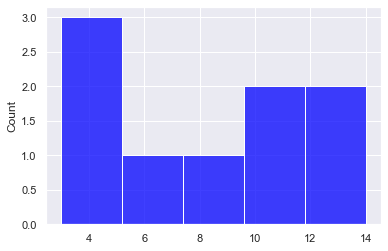

In [ ]:
f = plt.figure()
sns.histplot(data = features_per_card[:,1], color='blue')
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_features_syn_DS.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_features_syn_DS', dpi=300)

In [ ]:
additional_bad_card_list = np.hstack([additional_bad_card_list, features_per_card[features_per_card[:,1]<=MIN_FEATURES_NUM][:,0]])
additional_bad_card_list

array([], dtype=float64)

##### Общий промежуток времени между первой и последей транзакцией по картам

In [ ]:
#Время окна в которое укладываются все транзакции по карте
history_win = []
for i in df_sv_card.keys():
  history_win.append([i,df_sv_card[i]['DATE_TIME_SEC'].max()-df_sv_card[i]['DATE_TIME_SEC'].min()])
  #print(i,":",df_sv_card[i]['DATE_TIME_SEC'].max()-df_sv_card[i]['DATE_TIME_SEC'].min())
history_win = np.array(history_win)
print(history_win[history_win[:, 1].argsort()])

additional_bad_card_list = np.hstack([additional_bad_card_list, history_win[history_win[:,1]<=MIN_HISTORY_WINDOW][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

[[8.000000e+00 1.391357e+06]
 [5.000000e+00 2.241764e+06]
 [6.000000e+00 4.022480e+06]
 [4.000000e+00 4.030894e+06]
 [2.000000e+00 4.044856e+06]
 [3.000000e+00 4.187117e+06]
 [1.000000e+00 5.649787e+06]
 [7.000000e+00 8.359140e+06]
 [0.000000e+00 8.772414e+06]]
___________________________________________________________________________________
[]


##### Среднее время между транзакцийями


In [ ]:
#Среднее время между транзакциями по карте
mean_diff_time =[]
for i in df_sv_card.keys():
  mean_diff_time.append([i,df_sv_card[i]['TIME_DIFF'].mean()])
  #print(i,":",df_sv_card[i]['TIME_DIFF'].mean())
mean_diff_time = np.array(mean_diff_time)

#print(mean_diff_time[mean_diff_time[:, 1].argsort()])
temp_arr = mean_diff_time[mean_diff_time[:, 1].argsort()]
for i in range(len(temp_arr)):
  print(temp_arr[i][0],':',temp_arr[i][1])
additional_bad_card_list = np.hstack([additional_bad_card_list, mean_diff_time[mean_diff_time[:,1]<=MIN_MEAN_DIFF_TIME][:,0]])
print(eval("83*'_'"))
additional_bad_card_list = np.unique(additional_bad_card_list)
print(additional_bad_card_list)

8.0 : 3487.1102756892233
5.0 : 5618.456140350878
6.0 : 10081.403508771931
4.0 : 10102.491228070176
2.0 : 10137.483709273183
3.0 : 10494.027568922305
1.0 : 14159.8671679198
7.0 : 20950.225563909775
0.0 : 21986.0
___________________________________________________________________________________
[8.]


##### Удаление найденных плохих данных

In [ ]:
# Не будем удалять для равного количества крат
# additional_bad_card_list = additional_bad_card_list.astype(int)
# df_svista = df_svista.loc[~df_svista['CARDID_NUM'].isin(list(additional_bad_card_list))]
# df_svista

In [ ]:
df_svista

,CARDID_NUM,AMOUNT,AMOUNT_INST,DATE_TIME_SEC,MCC_freq,TERMINAL_ID_freq,AUTH_RESP_CODE_freq,PDC_CARDHOLDER_PRES_freq,MERCH_COUNTRY_freq,MERCH_CITY_freq,MERCH_POSTAL_CODE_freq,MERCH_ID_freq,CVV2_PRES_freq,TRANS_TYPE_freq,TIME_DIFF
0,0,7300,7300,1.503552e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,21986.0
1,0,36500,36500,1.506903e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,3350960.0
2,0,18000,18000,1.506904e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,1330.0
3,0,18000,18000,1.506951e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,46174.0
4,0,36500,36500,1.506973e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,22199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,8,18000,18049,1.512308e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,1999.0
3596,8,36500,36599,1.512310e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,1632.0
3597,8,3600,3610,1.512311e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,1119.0
3598,8,36500,36599,1.512311e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,89.0


### Визуализация

In [ ]:
df_svista_visual = df_svista.copy(deep=True)

dftemp = df_svista_visual.copy(deep=True)
dfn = dftemp.groupby('CARDID_NUM')['AMOUNT'].agg('count')
dftemp = pd.merge(dftemp, dfn, how='inner', left_on='CARDID_NUM', right_index=True)
dftemp.rename(columns={'AMOUNT_x': 'AMOUNT', 'AMOUNT_y': 'COUNT_OF_TRANSACTIONS'}, inplace=True)
df_svista_visual = dftemp.copy(deep=True)

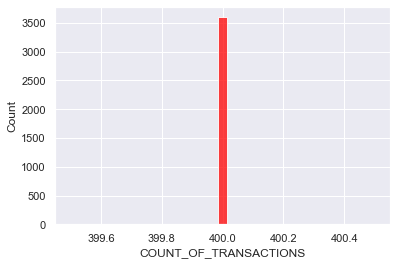

In [ ]:
f = plt.figure()
sns.histplot(df_svista_visual['COUNT_OF_TRANSACTIONS'],color='red', bins = int(350/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_transactions_final_syn_DS.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_transactions_final_syn_DS', dpi=300)

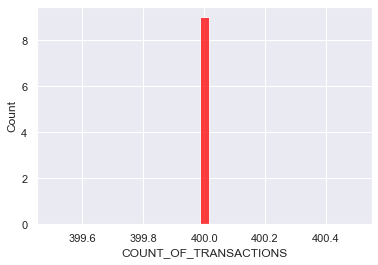

In [ ]:
df_claster_v = pd.DataFrame({'CARDID_NUM':list(df_svista['CARDID_NUM'].unique()),
                           'COUNT_OF_TRANSACTIONS':list(df_svista.groupby('CARDID_NUM')['AMOUNT'].agg('count'))})
f = plt.figure()
sns.histplot(df_claster_v['COUNT_OF_TRANSACTIONS'], color='red', bins = int(350/10))
if not os.path.isfile(f'{PNG_PATH}/hist_count_of_cards_final_syn_DS.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/hist_count_of_cards_final_syn_DS', dpi=300)

In [ ]:
df_sv_card = {}

In [ ]:
#Построение словаря содержащего транзакции по отдельным картам
for i in tqdm(df_svista_visual['CARDID_NUM'].unique()):
  df_sv_card[i]=df_svista_visual[df_svista_visual['CARDID_NUM']==i]
  #df_sv_card[i].drop(columns=['CARDID','CARDID_NUM','COUNT_OF_TRANSACTIONS'],inplace=True)
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 65.68it/s]


#### Количество транзакий в час

In [ ]:
df_sv_card.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

9it [00:01,  6.46it/s]


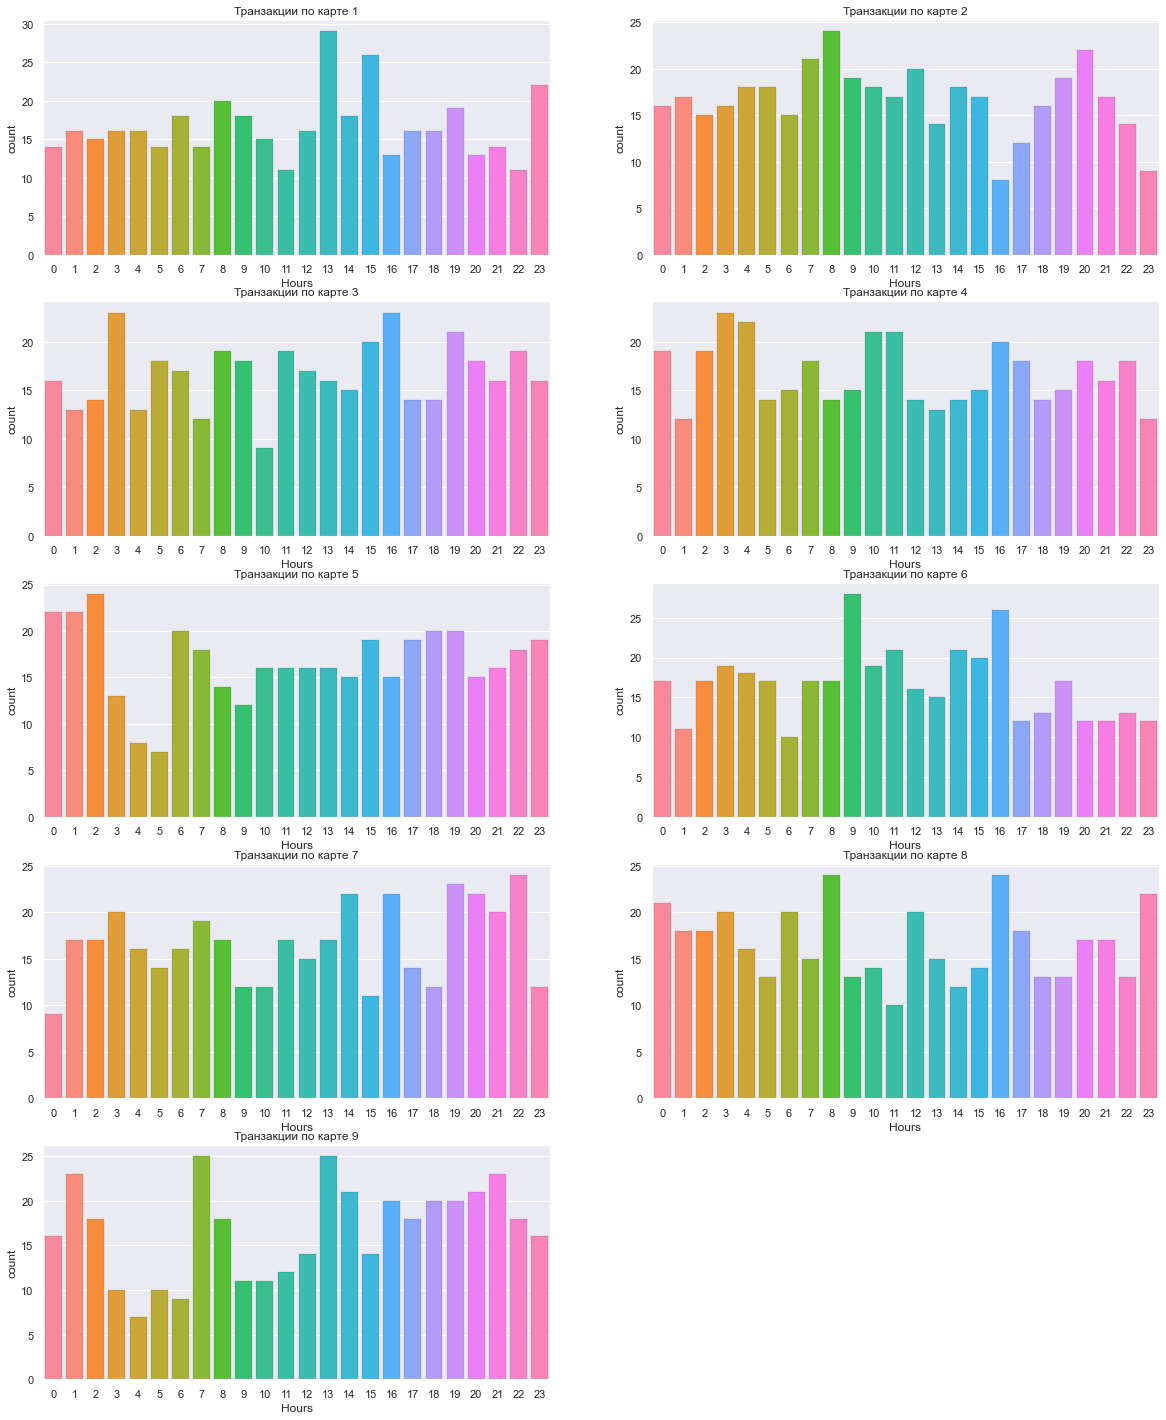

In [ ]:
%config InlineBackend.figure_format = 'png'
f = plt.figure(figsize=(20,25))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
gs = f.add_gridspec(math.ceil(len(df_sv_card.keys())/2), 2) # округленное в большую сторону деление на 2 количества карт
#gs = f.add_gridspec(math.ceil(94/2), 2)
for i, index  in tqdm(enumerate(df_sv_card.keys())): 
  df1 = df_sv_card[index].copy(deep=True)
  ####################
  minutes = df1['DATE_TIME_SEC']/60
  minutes = minutes.astype(int)
  df1['Minutes']=minutes
  hours = ((df1['Minutes']/60)) % 24
  hours = hours.astype(int)
  df1['Hours'] = hours
  ####################
  ax = f.add_subplot(gs[(int) (i/2), i % 2])
  ax.set_title(f"Транзакции по карте {i+1}")
  sns.countplot(data = df1,
                x = 'Hours',
                edgecolor=(0,0,0),
                linewidth=0.1,
                saturation=1)
plt.show()

In [ ]:
if not os.path.isfile(f'{PNG_PATH}/transactions_per_hour_syn_DS.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/transactions_per_hour_syn_DS', dpi=100)
#thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_hour_{thetime}.svg')
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_hour_{thetime}.png', dpi=300)

#### Количество транзакий в день

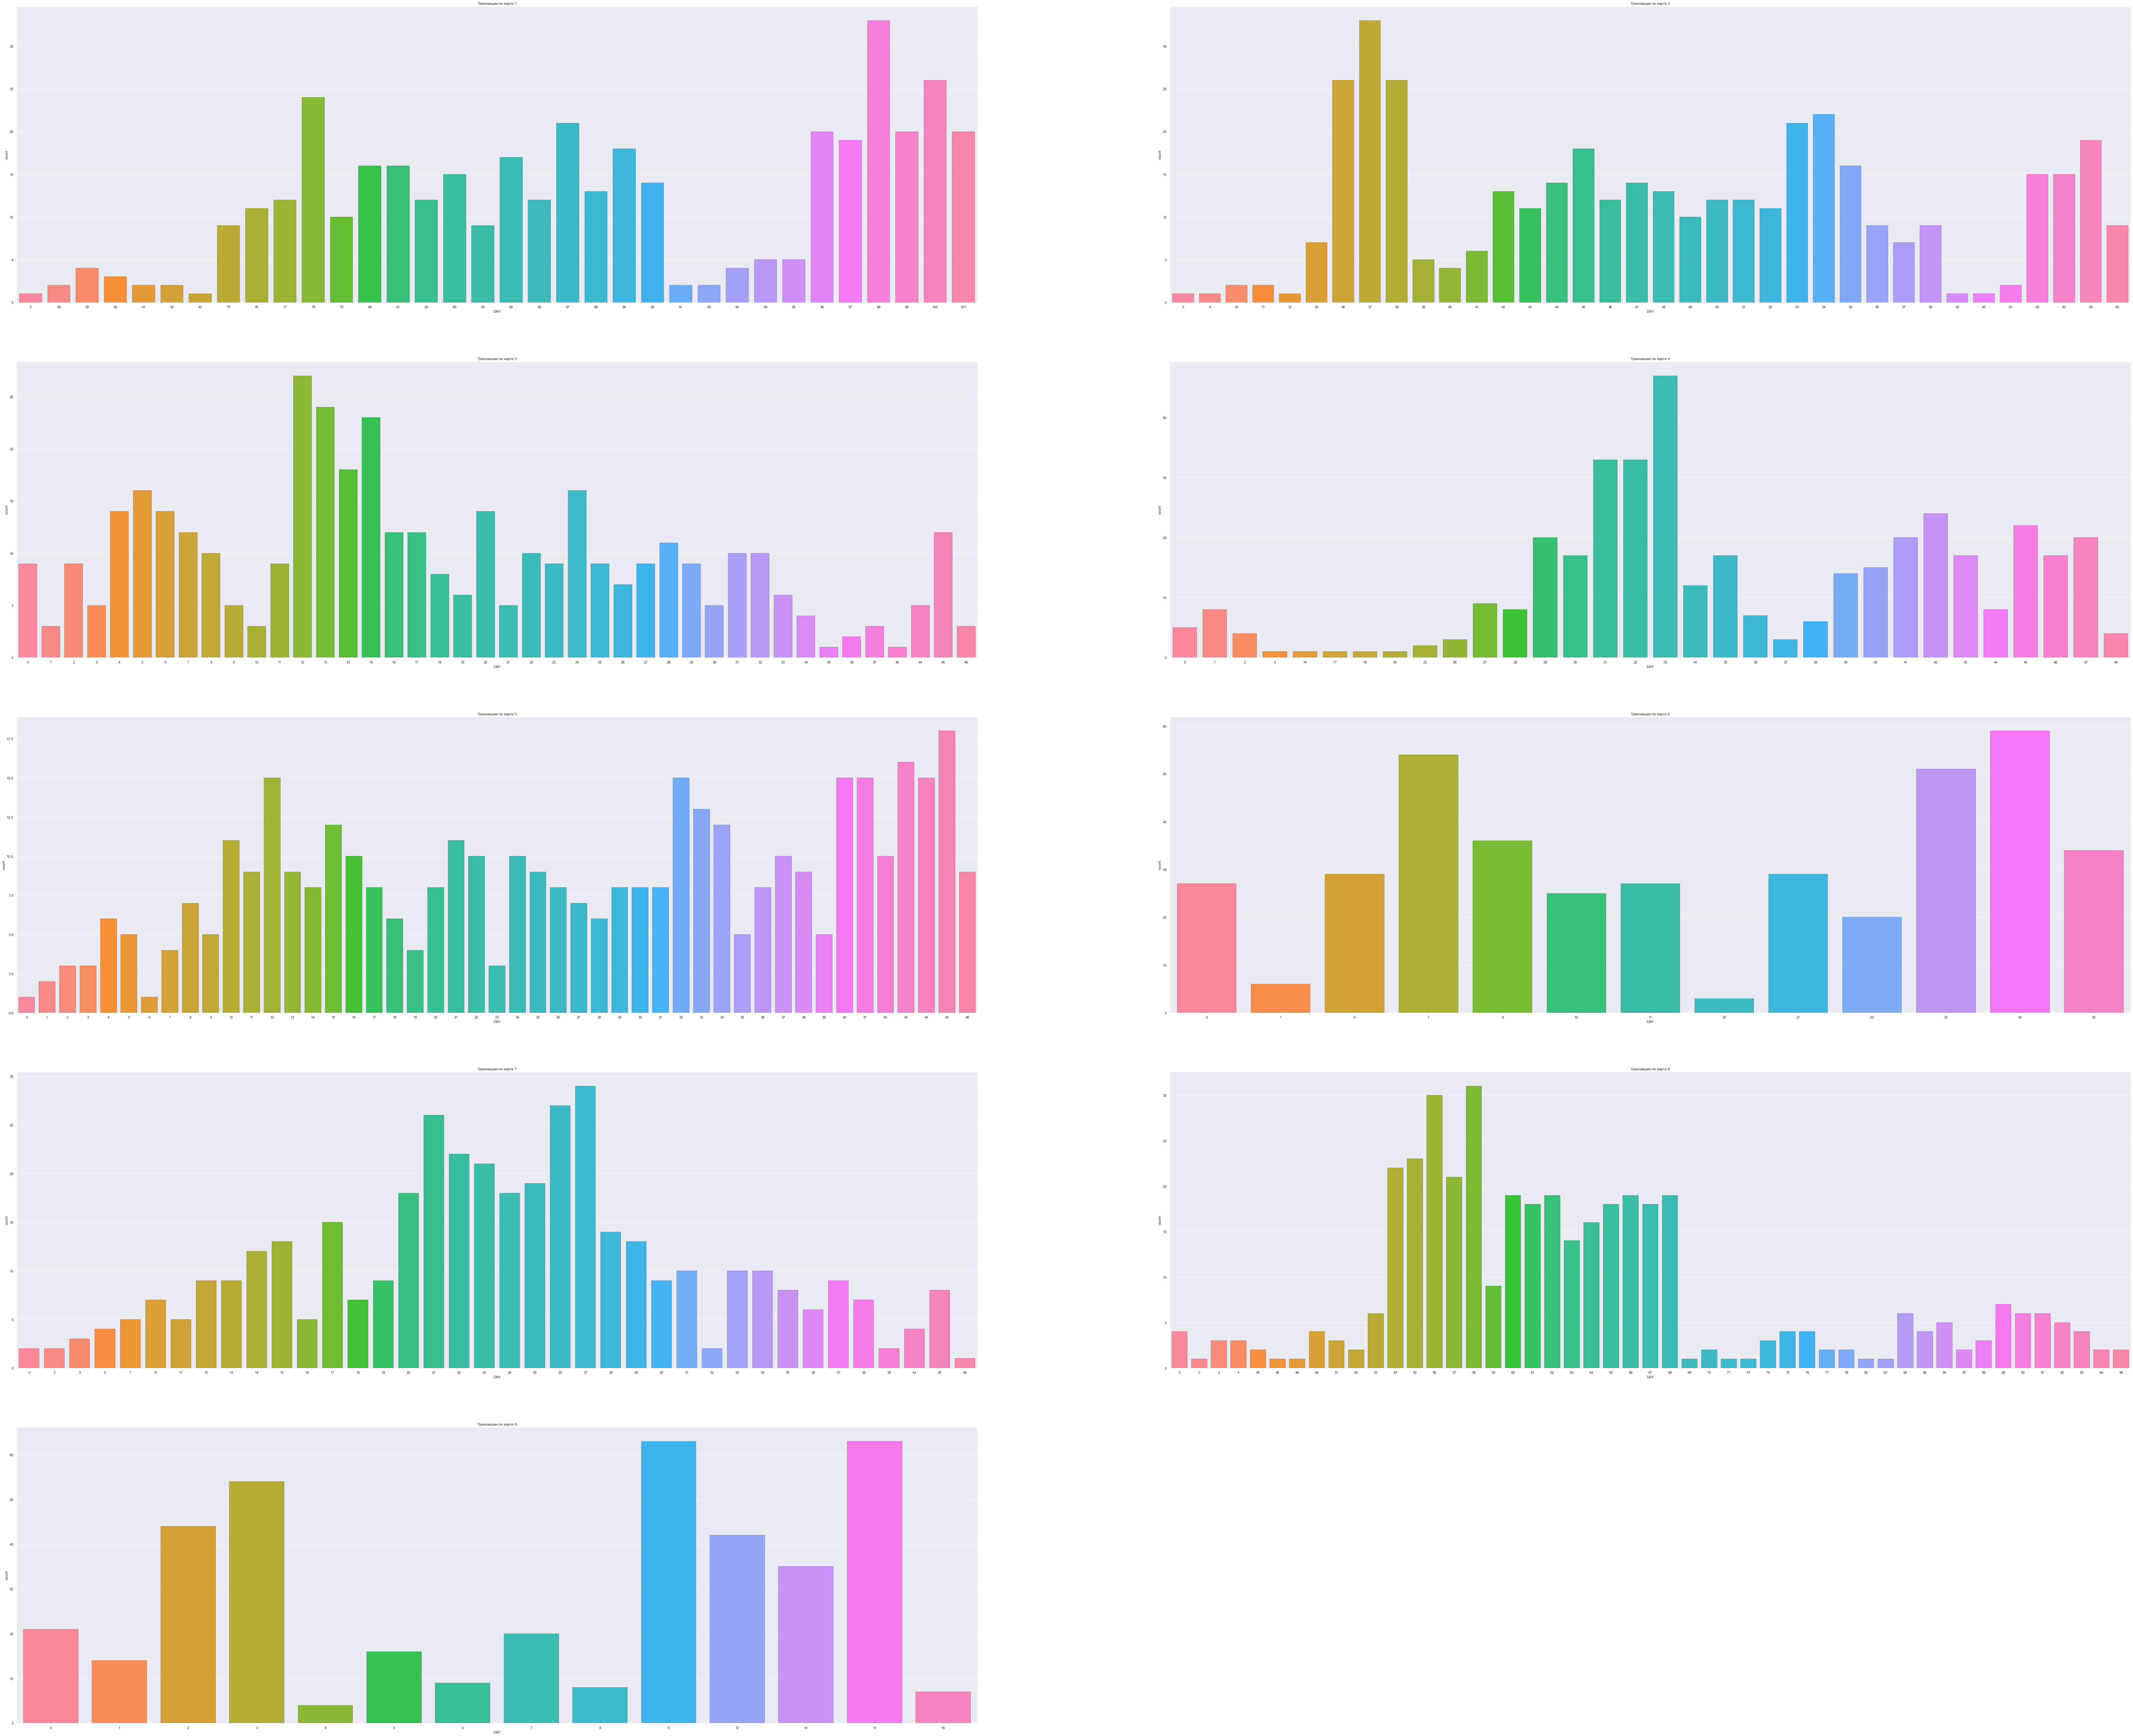

In [ ]:
%config InlineBackend.figure_format = 'png'
f = plt.figure(figsize=(120,100))
#plt.figure(figsize=(40,6))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
gs = f.add_gridspec(math.ceil(len(df_sv_card.keys())/2), 2)
for i, index in enumerate(df_sv_card.keys()): 
  df1 = df_sv_card[index].copy(deep=True)
  DAY = (df1['DATE_TIME_SEC']/86400)
  DAY = DAY.astype(int)
  df1['DAY']=DAY
  ax = f.add_subplot(gs[(int) (i/2), i % 2])
  ax.set_title(f"Транзакции по карте {i+1}")
  sns.countplot(data = df1,
                x = 'DAY',
                edgecolor=(0,0,0),
                linewidth=0.3,
                saturation=1)

plt.show()

In [ ]:
if not os.path.isfile(f'{PNG_PATH}/transactions_per_day_sym_DS.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  f.savefig(f'{PNG_PATH}/transactions_per_day_sym_DS', dpi=100)
#thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_day_{thetime}.svg')
#f.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_day_{thetime}.png', dpi=300)

#### Распределение всех транзакций по часам

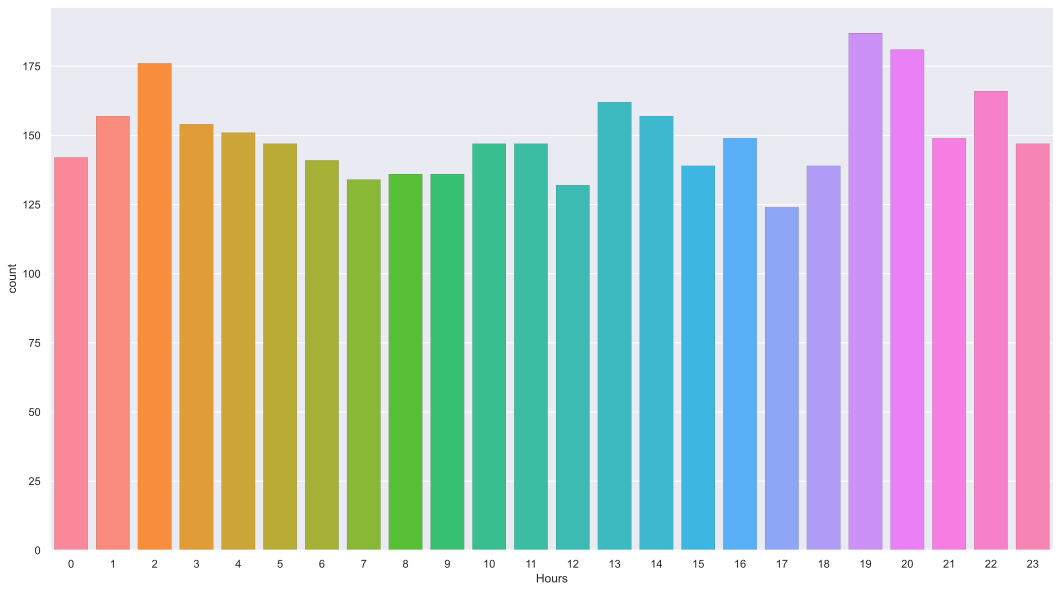

In [ ]:
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(18,10))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = df_svista_visual.copy(deep=True)
####################
minutes = df1['DATE_TIME_SEC']/60
minutes = minutes.astype(int)
df1['Minutes']=minutes
hours = ((df1['Minutes']/60)-417384) % 24
hours = hours.astype(int)
df1['Hours'] = hours
####################
sns.countplot(data = df1,
              x = 'Hours',
              edgecolor=(0,0,0),
              linewidth=0.1,
              saturation=1)
if not os.path.isfile(f'{PNG_PATH}/transactions_per_hour_ALL_syn_DS.png'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/transactions_per_hour_ALL_syn_DS', dpi=300)
#thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_hour_ALL27_{thetime}.svg')
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_hour_ALL27_{thetime}.png', dpi=300)
plt.show()

#### Распределение всех транзакций по дням

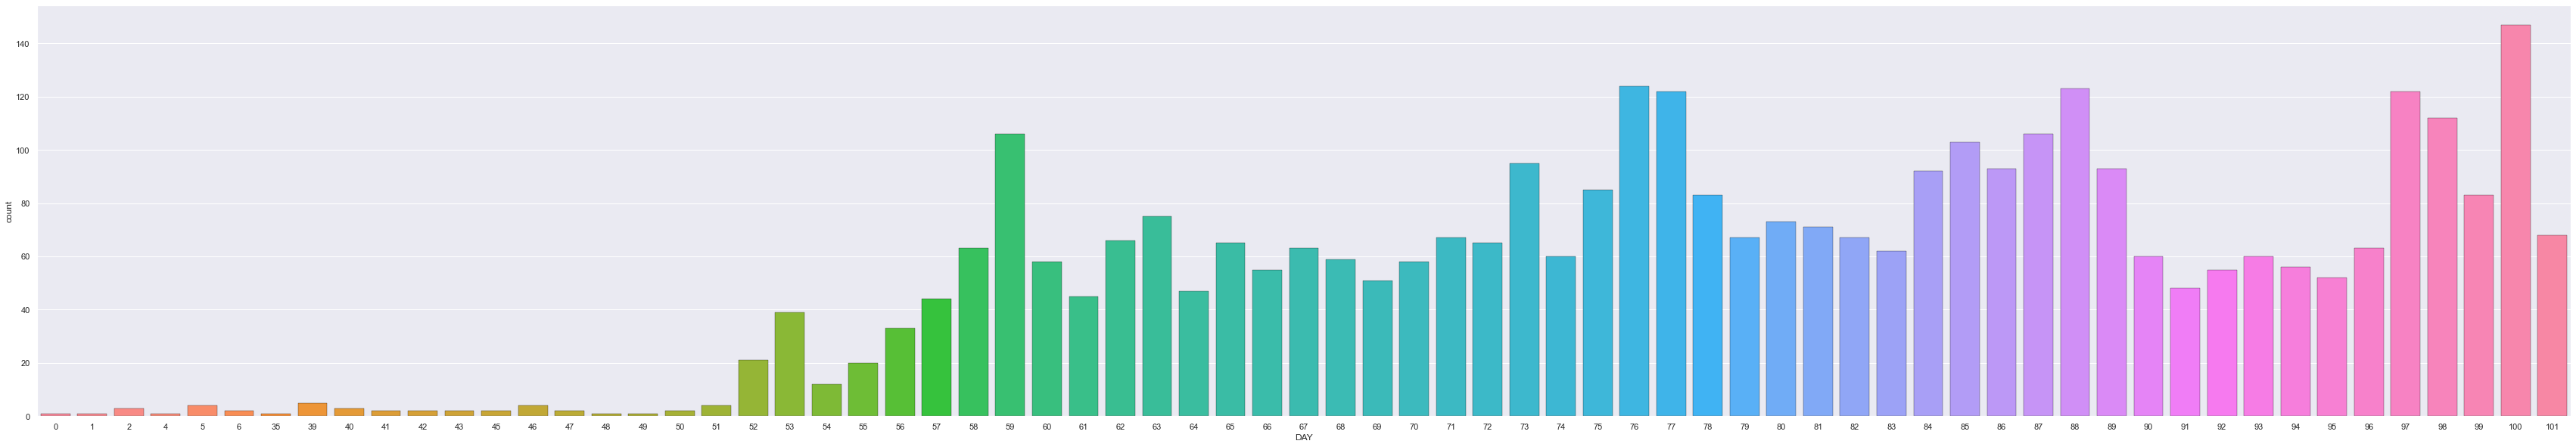

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.figure(figsize=(60,10))
#plt.figure(figsize=(40,6))
sns.set(style="darkgrid")
#plt.title("Count Plot of Transactions per each hour\n", fontsize=16)
#sns.set_context("paper", font_scale=1.4)
df1 = df_svista_visual.copy(deep=True)
DAY = (df1['DATE_TIME_SEC']/86400)
DAY = DAY.astype(int)
DAY = DAY - DAY.min()
df1['DAY']=DAY
sns.countplot(data = df1,
              x = 'DAY',
              edgecolor=(0,0,0),
              linewidth=0.3,
              saturation=1)
if not os.path.isfile(f'{PNG_PATH}/transactions_per_day_ALL_syn_DS'):
  #thetime = datetime.datetime.now().strftime("d%dm%mY%YH%HM%MS%S")
  plt.savefig(f'{PNG_PATH}/transactions_per_day_ALL_syn_DS', dpi=300)
#thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/svg/tran_per_day_ALL27_{thetime}.svg')
#plt.savefig(f'/Users/sudin/Рабочий стол/ERW 2020 7 sem DATA/photo/png/tran_per_day_ALL27_{thetime}.png', dpi=300)
plt.show()

### Сохранение

In [ ]:
if not os.path.isfile(f'{PREPROCESSED_DATA_PATH}prep_data_syn_DS.csv'):
  df_svista.to_csv(f'{PREPROCESSED_DATA_PATH}prep_data_syn_DS.csv', index=False)

In [ ]:
df_svista

,CARDID_NUM,AMOUNT,AMOUNT_INST,DATE_TIME_SEC,MCC_freq,TERMINAL_ID_freq,AUTH_RESP_CODE_freq,PDC_CARDHOLDER_PRES_freq,MERCH_COUNTRY_freq,MERCH_CITY_freq,MERCH_POSTAL_CODE_freq,MERCH_ID_freq,CVV2_PRES_freq,TRANS_TYPE_freq,TIME_DIFF
0,0,7300,7300,1.503552e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,21986.0
1,0,36500,36500,1.506903e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,3350960.0
2,0,18000,18000,1.506904e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,1330.0
3,0,18000,18000,1.506951e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,46174.0
4,0,36500,36500,1.506973e+09,0.003126,0.085719,0.544423,0.68131,0.356532,0.059724,0.064988,0.001892,0.530355,0.66823,22199.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,8,18000,18049,1.512308e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,1999.0
3596,8,36500,36599,1.512310e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,1632.0
3597,8,3600,3610,1.512311e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,1119.0
3598,8,36500,36599,1.512311e+09,0.073955,0.016617,0.544423,0.68131,0.356532,0.059724,0.064988,0.044587,0.530355,0.66823,89.0


In [ ]:
print('Кол-во признаков:', len(df_svista.columns))
print(list(df_svista.columns))
print(df_svista.info())
for column in df_svista.columns:
  print(eval("83*'_'"),'\n',"Column: ", column,"  Num of unique: ", len(df_svista[column].unique()), '\n', "Unique data:", df_svista[column].unique()[:5], sep='')

Кол-во признаков: 15
['CARDID_NUM', 'AMOUNT', 'AMOUNT_INST', 'DATE_TIME_SEC', 'MCC_freq', 'TERMINAL_ID_freq', 'AUTH_RESP_CODE_freq', 'PDC_CARDHOLDER_PRES_freq', 'MERCH_COUNTRY_freq', 'MERCH_CITY_freq', 'MERCH_POSTAL_CODE_freq', 'MERCH_ID_freq', 'CVV2_PRES_freq', 'TRANS_TYPE_freq', 'TIME_DIFF']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CARDID_NUM                3600 non-null   int64  
 1   AMOUNT                    3600 non-null   int64  
 2   AMOUNT_INST               3600 non-null   int64  
 3   DATE_TIME_SEC             3600 non-null   float64
 4   MCC_freq                  3600 non-null   float64
 5   TERMINAL_ID_freq          3600 non-null   float64
 6   AUTH_RESP_CODE_freq       3600 non-null   float64
 7   PDC_CARDHOLDER_PRES_freq  3600 non-null   float64
 8   MERCH_COUNTRY_freq        3600 non-null   f